# Verification Document

This document is designed to load and check the data taken from the NCBI database

Assumptions:
- For a phage with multiple interactions, chose the bacteria that has the highest number of interactions with all phages
- For phages with >10 proteins, selected the first 10 proteins in the list
    - Can come back and select most useful instead of randomly picking ten
- Set cutoff for useful proteins between 200 on the small side (seen in literature) and 1024 (ESM context length)

## Load the phage-bacteria interaction label datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import json
import re

from Bio import Entrez
from Bio import SeqIO
from io import StringIO

import psycopg2
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split

In [2]:
#Data from VMR
df1 = pd.read_excel('data/VMR_MSL38_v3.xlsx')

#Data from Virus-Host DB
df2 = pd.read_csv('data/virushostdb.tsv', delimiter='\t')
df2.drop(['KEGG GENOME', 'KEGG DISEASE', 'DISEASE'], inplace=True, axis=1) #Dropping unhelpful columns

In [3]:
def clean_and_filter_df(df):

    #Add a column that pulls out the host type
    def parse_host_type(x):
        x = str(x)
        return x.split(';')[0]
    
    def select_first_refseqid(x):
        try: 
            first_name = x.split(',')[0]
        except:
            first_name = x
        return first_name

    df['host_type'] = df['host lineage'].map(parse_host_type)

    #Trim the dataframe to bacteria only
    df_bacteria = df[df['host_type'] == 'Bacteria']

    #Set up a threshold for minimum number of interactions per bacteria
    cutoff_value = 20
    df_groupby_bacteria = df_bacteria.groupby('host name')
    sorted_bacteria_count = np.sort(df_groupby_bacteria['host name'].count().values)[::-1]
    count = df_groupby_bacteria['host name'].count()
    filtered_names = list(count[count >= cutoff_value].index)

    df_bacteria_filtered = df_bacteria[df_bacteria['host name'].isin(filtered_names)]

    #Select the first refseq id in the rare case that multiple id's are listed in this column
    df_bacteria_filtered.loc[:, 'refseq id'] = df_bacteria_filtered['refseq id'].map(select_first_refseqid)

    #Summarize
    print(f'The filtered dataset includes {df_bacteria_filtered.shape[0]} samples from {len(filtered_names)} different bacteria')
    print(f'All bacteria have at least {cutoff_value} samples each')

    return df_bacteria_filtered


df_bacteria_filtered = clean_and_filter_df(df2)

The filtered dataset includes 13756 samples from 135 different bacteria
All bacteria have at least 20 samples each


In [4]:
df_bacteria_filtered.head(2)

,virus tax id,virus name,virus lineage,refseq id,host tax id,host name,host lineage,pmid,evidence,sample type,source organism,host_type
48,3061295,Achromobacter phage 2-1,Viruses; Duplodnaviria; Heunggongvirae; Urovir...,OQ974181,85698.0,Achromobacter xylosoxidans,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,RefSeq,NaN,NaN,Bacteria
49,1589747,Achromobacter phage 83-24,Viruses; Duplodnaviria; Heunggongvirae; Urovir...,NC_028834,85698.0,Achromobacter xylosoxidans,Bacteria; Pseudomonadota; Betaproteobacteria; ...,24466294,"Literature, RefSeq",NaN,NaN,Bacteria


In [5]:
df_bacteria_filtered.groupby('host name')['refseq id'].count().sort_values(ascending=False)

host name
Mycolicibacterium smegmatis MC2 155                        1727
Escherichia coli                                           1033
Klebsiella pneumoniae                                       665
Gordonia terrae                                             518
Mycolicibacterium smegmatis                                 466
                                                           ... 
Synechococcus                                                20
Pectobacterium carotovorum subsp. carotovorum                20
Streptococcus equi                                           20
Yersinia enterocolitica (type O:3)                           20
Salmonella enterica subsp. enterica serovar Paratyphi A      20
Name: refseq id, Length: 135, dtype: int64

In [6]:
df_bacteria_filtered.groupby('host name')['refseq id'].count().sort_values(ascending=False)[1:5].sum()

2682

## Load the NCBI Tail Protein Data

In [3]:
#Pull data from CSV file -> converted from SQL table created in 'Exploration.ipynb' file
df_protein = pd.read_csv('data/protein_data_2024_06_04.csv', delimiter=',')
df_protein.head(2)

,phage_name,refseq_id,protein_label,protein_sequence
0,Achromobacter phage 2-1,OQ974181,tail length tape measure protein chaperone,MSNHQAPASKRPLDRIKIMVNGETRDLFMSFGLLNELCALIPDAHA...
1,Achromobacter phage 2-1,OQ974181,tail length tape measure protein,MATSNQVDKGQVDLTLNQQVFDDVRKLESSLQGVLKTLNSVSSAFK...


In [4]:
print(f'There are {len(df_protein["refseq_id"].unique())} unique viruses with tail protein information')

There are 11316 unique viruses with tail protein information


#### Look at the distribution of protein lengths

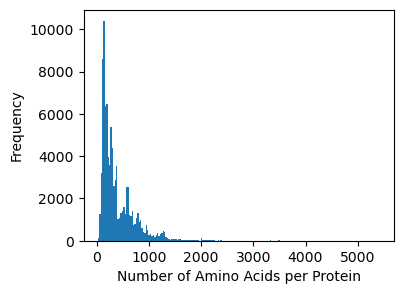

In [5]:
df_protein['protein_length'] = df_protein['protein_sequence'].map(lambda x: len(x))

plt.figure(figsize=(4, 3))
plt.hist(df_protein['protein_length'], bins = 200)
plt.xlabel('Number of Amino Acids per Protein')
plt.ylabel('Frequency')
plt.show()

In [6]:
min_prot_length = 200
max_prot_length = 1024
num_filtered_prot = len(df_protein[(df_protein['protein_length'] >= min_prot_length) & (df_protein['protein_length'] <= max_prot_length)])

print(f'{num_filtered_prot} of {len(df_protein)} tail proteins have a length between {min_prot_length} to {max_prot_length} amino acids')

53092 of 93295 tail proteins have a length between 200 to 1024 amino acids


In [7]:
num_small_proteins = df_protein[df_protein['protein_length'] <= min_prot_length].count()[0]
num_large_proteins = df_protein[df_protein['protein_length'] >= max_prot_length].count()[0]
print(f'There are {num_small_proteins} proteins smaller than the {min_prot_length} AA cutoff limit')
print(f'There are {num_large_proteins} proteins larger than the 1024 context length')

There are 35308 proteins smaller than the 200 AA cutoff limit
There are 5155 proteins larger than the 1024 context length


Note: 1024 is the context length cutoff for ProtBERT and ESM Models.  200 is an arbitrary minimum cutoff seen in literature. 

In [8]:
#Create a trimmed df that contains only proteins within min_prot_length <= AA <= max_prot_length
df_protein_trimmed = df_protein[(df_protein['protein_length'] >= min_prot_length) & (df_protein['protein_length'] <= max_prot_length)]
len(df_protein_trimmed)

53092

#### Look at distribution of number of proteins in database per virus

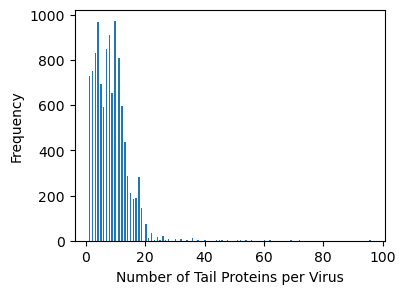

In [13]:
#Group by the specific viruses
df_protein_groupby = df_protein.groupby('refseq_id')

#Plot the frequency 
plt.figure(figsize=(4, 3))
plt.hist(df_protein_groupby['phage_name'].count().values, bins = 200)
plt.xlabel('Number of Tail Proteins per Virus')
plt.ylabel('Frequency')
plt.show()

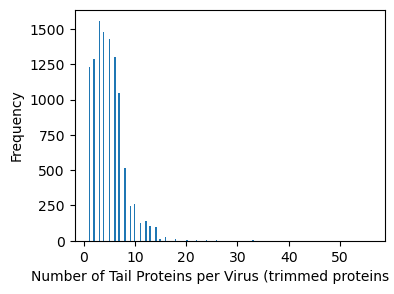

In [9]:
#Group by the specific viruses
df_protein_groupby_trimmed = df_protein_trimmed.groupby('refseq_id')

#Plot the frequency 
plt.figure(figsize=(4, 3))
plt.hist(df_protein_groupby_trimmed['phage_name'].count().values, bins = 200)
plt.xlabel('Number of Tail Proteins per Virus (trimmed proteins only)')
plt.ylabel('Frequency')
plt.show()

In [15]:
protein_cutoff = 10
num_virus_after_trimmed_proteins = len(df_protein_groupby_trimmed['phage_name'].count())
num_too_many_proteins = (df_protein_groupby_trimmed['phage_name'].count() > protein_cutoff).sum()
print(f'There are {num_too_many_proteins} of {num_virus_after_trimmed_proteins} viruses with >{protein_cutoff} associated proteins, where each protein has AA length between 200-1024')
print(f'This is {num_too_many_proteins/num_virus_after_trimmed_proteins*100:0.1f}% of viruses')

There are 548 of 10916 viruses with >10 associated proteins, where each protein has AA length between 200-1024
This is 5.0% of viruses


#### Examine most common protein type labels

In [16]:
df_protein_groupby = df_protein.groupby('protein_label')
df_protein_groupby['phage_name'].count().sort_values(ascending=False)

protein_label
minor tail protein                                                   21786
tail assembly chaperone                                               8190
tail protein                                                          5976
major tail protein                                                    5580
tail fiber protein                                                    5500
                                                                     ...  
putative pore forming tail tip protein                                   1
putative prophage tail fiber N-terminal domain-containing protein        1
putative protail assembly protein                                        1
putative proximal hinge connector of long tail fiber                     1
virion protein, putative tail protein                                    1
Name: phage_name, Length: 1460, dtype: int64

#### Apply regex to isolate impactful proteins
Used regex sequence observed in literature to identify the most impactful proteins based on their respective labels

In [17]:
def run_regex_on_protein_label(x):
    '''function to perform regex search on protein labels.  Regex search
    pulled from literature'''
    pattern = re.compile(r'tail?(.?|\s*)(?:spike?|fib(?:er|re))|recept(?:o|e)r(.?|\s*)(?:bind|recogn).*(?:protein)?|(?<!\w)RBP(?!a)')
    if pattern.search(x): return 1
    else: return 0

#Create copies of dataframes to perform analysis
df_protein_regex = df_protein.copy()
df_protein_trimmed_regex = df_protein_trimmed.copy()

# Run regex over protein labels
df_protein_regex['regex'] = df_protein_regex['protein_label'].apply(run_regex_on_protein_label)
df_protein_trimmed_regex['regex'] = df_protein_trimmed_regex['protein_label'].apply(run_regex_on_protein_label)

# Keep samples with a successful regex run
df_protein_regex = df_protein_regex[df_protein_regex['regex'] == 1]
df_protein_trimmed_regex = df_protein_trimmed_regex[df_protein_trimmed_regex['regex'] == 1]


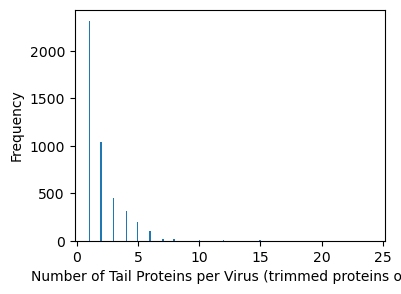

In [18]:
#Group by the specific viruses
df_protein_groupby_trimmed_regex = df_protein_trimmed_regex.groupby('refseq_id')

#Plot the frequency 
plt.figure(figsize=(4, 3))
plt.hist(df_protein_groupby_trimmed_regex['phage_name'].count().values, bins = 200)
plt.xlabel('Number of Tail Proteins per Virus (trimmed proteins only)')
plt.ylabel('Frequency')
plt.show()

Over half of the phages remaining have only one protein associated with them.  May make classification difficult if that protein is not actually impactful.

In [19]:
print(f'Original number of phages in the trimmed dataframe is: {len(df_protein_trimmed["refseq_id"].unique())}')
print(f'Number of phages in the trimmed dataframe after regex is: {len(df_protein_trimmed_regex["refseq_id"].unique())}')

Original number of phages in the trimmed dataframe is: 10916
Number of phages in the trimmed dataframe after regex is: 4475


---

## Load the NCBI DNA Data

In [20]:
#Pull data from CSV file -> converted from SQL table created in 'Exploration.ipynb' file
df_DNA= pd.read_csv('data/DNA_data_2024_06_04.csv', delimiter=',')
df_DNA.head()

,phage_name,refseq_id,taxonomy,gene_length,gene_sequence
0,Achromobacter phage 2-1,OQ974181,"{Viruses,Duplodnaviria,Heunggongvirae,Uroviric...",82711,GACGCCTTACTGTGGCGCAGAAACAACACCGCTACCACGCCTACGC...
1,Achromobacter phage 83-24,NC_028834,"{Viruses,Duplodnaviria,Heunggongvirae,Uroviric...",48216,GCACTTCATGCAGCATGAACATGGACAATGTCCCAAACTGGGACTT...
2,Achromobacter phage AXY1,OK041469,"{Viruses,Duplodnaviria,Heunggongvirae,Uroviric...",61950,GAAGATGTGTATAATCGGCAGCCGCGTACCTCTTCTGACCCCGCCA...
3,Achromobacter phage JWAlpha,NC_023556,"{Viruses,Duplodnaviria,Heunggongvirae,Uroviric...",72329,ACACACCCCCCCGGTGTCTTGCTCCTGTGCACCTCTACCCACCCCC...
4,Achromobacter phage JWDelta,KF787094,"{Viruses,Duplodnaviria,Heunggongvirae,Uroviric...",73659,TTGCGTCACACCCACCCCCGGTGTCTTGCTCCTGTGCACCTCTACC...


In [21]:
#Summarize
print(f'There are {len(df_DNA)} viruses in the DNA table')
print(f'There are {len(df_DNA["refseq_id"].unique())} unique viruses with genomic information')

There are 13827 viruses in the DNA table
There are 13467 unique viruses with genomic information


In [22]:
#Collect refseq/genbank id's from the two dataframes for comparison
VHDB_refseq_ids = list(df_bacteria_filtered['refseq id'].unique())
NCBI_refseq_ids = list(df_DNA['refseq_id'].unique())

In [23]:
print(f'There are {len(VHDB_refseq_ids)} unique viruses in the original VHDB database')
print(f'There are {len(NCBI_refseq_ids)} viruses in the DNA table')

There are 13395 unique viruses in the original VHDB database
There are 13467 viruses in the DNA table


In [24]:
#Identify refseq/genbank ID's that are in VirusHostDB, but not in SQL database
refseq_ids_to_add = []
for refseq_id in VHDB_refseq_ids:
    if refseq_id not in NCBI_refseq_ids:
        refseq_ids_to_add.append(refseq_id)

refseq_ids_to_add

['OM418625', 'OX001802']

- On the first pass there were ~75 id's that were in `df_bacteria_filtered` and not in `df_DNA`
    - After running API call on those id's, there are 2 that continued to fail
        - ['OM418625', 'OX001802']

In [25]:
#See which viruses are recorded multiple times in the DNA database
df_DNA.groupby('refseq_id')['phage_name'].count().sort_values(ascending=False)[0:315]

refseq_id
NC_001421    6
NC_071043    4
NC_049396    4
NC_049962    4
NC_028890    4
            ..
MH576956     2
MH536825     2
NC_048755    1
NC_048868    1
NC_048870    1
Name: phage_name, Length: 315, dtype: int64

Note: 
- May need to reduce this to one interaction per phage for prediction purposes
- Have seen in literature that people pick the bacteria that has the most PBI's as the interaction to keep


___

# Combine All Data into One DataFrame

### Select Top Bacteria for Phages with Multiple Interactions 

Some phages have interactions with multiple bacteria.  Need to only have 1 bacteria interaction listed per phage (outcome variable).  Will select the most common bacteria as the top bacteria for each phage that has multiple interactions.

In [26]:
def assign_top_bacteria_to_phage(df_bacteria_filtered):
    '''Some phages have interactions with multiple bacteria.  There are 313 out of 
    ~13500 in this dataset.  Consistent with literature, the bacteria with the highest
    number of interactions in the dataset will be applied as the single interaction
    for a phage with multiple interactions'''

    def select_top_bacteria(x, bacteria_df):
        '''The workhorse function that calculates which bacteria has the highest number of 
        interactions for bacteria that interact with a given phage

        Intented to be applied to a dataframe'''
        top_bacteria = ''
        top_count = 0
        for bacteria in x:
            try: 
                current_count = bacteria_df[bacteria_df['host name'] == bacteria]['refseq id'].item()
            except:
                current_count = 0
                print('failed here')
            if current_count > top_count:
                top_count = current_count
                top_bacteria = bacteria
        return top_bacteria

    # Group the df by phage refseq id, with a list of bacteria that it
    # interacts with in the 'host name' column
    df_group = df_bacteria_filtered.groupby('refseq id')
    df_phages = df_group['host name'].agg(list).reset_index()  

    # Create a dataframe that contains a count of the number of interactions
    # listed by bacteria name 
    df_bacteria_count= df_bacteria_filtered.groupby('host name')['refseq id'].count().reset_index()

    # Apply calculation of top bacteria for each phage
    df_phages['top host name'] = df_phages['host name'].apply(lambda x: select_top_bacteria(x,df_bacteria_count))

    df_phages = df_phages[['refseq id', 'top host name']].rename(columns={'refseq id':'refseq_id', 'top host name':'host_name'})

    return df_phages

In [27]:
def regex_to_curate_tail_protein(df):
    '''Function to run the regex from literature that identifies the most impactful proteins based on their
    named labels.  Will remove protein data from df that are not identified in the regex'''
    def run_regex_on_protein_label(x):
        '''function to perform regex search on protein labels.  Regex search
        pulled from literature'''
        pattern = re.compile(r'tail?(.?|\s*)(?:spike?|fib(?:er|re))|recept(?:o|e)r(.?|\s*)(?:bind|recogn).*(?:protein)?|(?<!\w)RBP(?!a)')
        if pattern.search(x): return 1
        else: return 0

    # Run regex over protein labels
    df['regex'] = df['protein_label'].apply(run_regex_on_protein_label)

    # Keep samples with a successful regex run
    df = df[df['regex'] == 1]
    
    #Drop the regex column
    df.drop('regex', axis=1, inplace=True)
    return df

In [28]:
df_top_bacteria_by_phage = assign_top_bacteria_to_phage(df_bacteria_filtered)
df_top_bacteria_by_phage.head(2)

,refseq_id,host_name
0,AB626963,Staphylococcus aureus
1,AB910392,Pseudomonas


In [29]:
df_protein = pd.read_csv('data/protein_data_2024_06_04.csv', delimiter=',')

### Combine Protein data, DNA Data, and Labeled Data into One Dataframe

In [30]:
# Set up flag to pass through regex or not
use_regex = True

In [ ]:
# Filter out proteins that are too large or too small
min_prot_length = 200
max_prot_length = 1024
df_protein_filtered = df_protein[(df_protein['protein_sequence'].str.len() >= min_prot_length) & (df_protein['protein_sequence'].str.len() <= max_prot_length)]

if use_regex:
    # Pass protein labels through regex and remove
    df_protein_filtered = regex_to_curate_tail_protein(df_protein_filtered)

# Group the dataframe by refseq_id to create a list of proteins and merge with bacteria df to assign 
# corresponding host_name for phage
grouped_data_df = df_protein_filtered.groupby('refseq_id').agg(list).reset_index()
grouped_data_df = pd.merge(grouped_data_df, df_top_bacteria_by_phage, on='refseq_id', how='inner')[['refseq_id', 'protein_label', 'protein_sequence', 'host_name']]

# Select first 10 proteins for phage if a phage has >10 proteins
grouped_data_df['protein_sequence'] = grouped_data_df['protein_sequence'].apply(lambda x: x[:10] if len(x) > 10 else x)

# Add DNA sequences.  Drop duplicates since some phages are in DNA sequence twice.  It's been confirmed
# that they have the same DNA sequence and were just queried twice to the NCBI database
grouped_data_df = pd.merge(grouped_data_df, df_DNA, on='refseq_id', how='inner')[['refseq_id', 'protein_label', 'protein_sequence', 'gene_sequence', 'host_name']]
grouped_data_df = grouped_data_df.drop_duplicates(subset=['refseq_id'], keep='first')

##### Save Compiled Dataframe

In [128]:
# Convert protein_sequence column to JSON format so the list structure can be maintained
grouped_data_df['protein_sequence'] = grouped_data_df['protein_sequence'].apply(json.dumps)
grouped_data_df['protein_label'] = grouped_data_df['protein_label'].apply(json.dumps)

#Save File
#file_path = '/Users/blakebleier/Library/CloudStorage/GoogleDrive-blable543@gmail.com/My Drive/DS_266_Final_Project_PBI/data/filtered_data/dna_protein_compiled_2024_07_03.csv'
file_path = '/Users/blakebleier/Library/CloudStorage/GoogleDrive-blable543@gmail.com/My Drive/DS_266_Final_Project_PBI/data/filtered_data/dna_protein_compiled_curated_2024_07_20.csv'
grouped_data_df.to_csv(file_path, index=False)

##### Load Compiled Dataframe

In [129]:
# Load dataframe from the saved csv file
grouped_data_df_new = pd.read_csv(file_path)

# Convert JSON strings back to lists
grouped_data_df_new['protein_sequence'] = grouped_data_df_new['protein_sequence'].apply(json.loads)
grouped_data_df['protein_label'] = grouped_data_df['protein_label'].apply(json.dumps)

In [130]:
grouped_data_df_new.head(3)

,refseq_id,protein_label,protein_sequence,gene_sequence,host_name
0,AF527608,"[""tailspike protein""]",[MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPAN...,AGAGAAGATTTATCTGAAGTCGTTACGCGAGCAGAACAGGTCATCT...,Salmonella enterica subsp. enterica serovar Ty...
1,AJ304858,"[""putative tail fiber component Z"", ""putative ...",[MSMAIKGLAQAMKNLDAIDRRAVPRAAATTLNRVAESIIAKTASS...,CATCCGTTCCATTTCGAGATCGGACGTGGCGACCAGCATCTTGCCG...,Escherichia coli
2,AM076770,"[""tail fiber protein 1"", ""tail fiber protein 2...",[MNDNAVDFDKIFASAAPIERDLEEHEYLKGWAYLDEKAPEFEDFD...,GGGCGGCGACCTCCGCTCCTGCGGGTCAGGGCGGCGGGCCTTGCCT...,Yersinia pestis


#### Shuffle the data and split into train/test/val

In [219]:
df_shuffled = grouped_data_df_new.sample(frac=1, random_state=1234)  

In [220]:
# Set the ratios for splitting into train/test/val sets
train_size = int(len(grouped_data_df_new) * 0.8)
validation_size = int(len(grouped_data_df_new) * 0.1)
test_size = len(grouped_data_df_new) - train_size - validation_size

# Split the data into training and temporary set (temporary set will be split into validation and test)
train_df, temp_df = train_test_split(df_shuffled, train_size=train_size, random_state=1234)

# Split the temporary set into validation and test sets
validation_df, test_df = train_test_split(temp_df, test_size=test_size, random_state=1234)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(validation_df)}")
print(f"Test size: {len(test_df)}")

Train size: 8700
Validation size: 1087
Test size: 1089
